<h1> Feature Engineering Notebook </h1>


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<pre>
    base-dir-format :{
        - train (contain all train images)
        - test  (contain all test images)
        - xml   (Annotations of all train images)
        - csv file
        - video in mp4 format
        - .ci file
        }

  # After Running this notebook it should be like :
  
    base-dir-format :{
   'TownCentre-calibration.ci',
    'TownCentre-groundtruth.top',
    'TownCentreXVID.mp4',
    'train',
    'test',
    'xmls',
    'aug_images',
    'xmls_augmented_1',
    'train.record',
    'val.record'
    }
</pre>

<h1> Libraries </h1>

In [3]:
pip install tensorflow==1.13.1

     |████████████████████████████████| 92.6MB 36kB/s 
     |████████████████████████████████| 3.2MB 41.4MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 368kB 37.9MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [4]:
pip install tensorflow-object-detection-api

     |████████████████████████████████| 583kB 10.2MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 3.2MB 19.6MB/s 
  Created wheel for tensorflow-object-detection-api: filename=tensorflow_object_detection_api-0.1.1-cp37-none-any.whl size=844515 sha256=c01c869b23af89487fda052108fcc0e38511df401f9a0c6b4e3e3b4b3badd82c
  Stored in directory: /root/.cache/pip/wheels/4a/54/d0/cfca11930c4b2025d40dede77059094070a67cc3e7bd3b285f
Successfully built tensorflow-object-detection-api


In [5]:
pip install xmljson

In [6]:
import hashlib
import io
import logging
import os
import random
import re

from lxml import etree
import PIL.Image
import tensorflow as tf
from xmljson import parker
from xml.etree.ElementTree import fromstring

from object_detection.utils import dataset_util
from object_detection.utils import label_map_util

###

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import tensorflow as tf

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

import imgaug as ia
ia.seed(1)
# imgaug uses matplotlib backend for displaying images
%matplotlib inline
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 
# imageio library will be used for image input/output
import imageio
import pandas as pd
import numpy as np
import re
import os
import glob
# this library is needed to read XML files for converting it into CSV
import xml.etree.ElementTree as ET
import shutil
from tqdm import tqdm
import pickle

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

<h1> Declaring paths </h1>

['TownCentre-calibration.ci',
 'TownCentre-groundtruth.top',
 'TownCentreXVID.mp4',
 'train',
 'test',
 'xmls',
 'aug_images',
 'xmls_augmented_1',
 'train.record',
 'val.record']

In [17]:
length = 7502

common_path = "/content/drive/MyDrive/Townhall_dataset/OxfordTownCentre"

csv_file = common_path + "/" + os.listdir(common_path)[1]
video_file = common_path + "/" + os.listdir(common_path)[2]

print("Declaring path to raw data :")
print("="*50)
print("common_path :",common_path)
print("csv_file    :",csv_file)
print("video_file  :",video_file)

print()

train = common_path + "/" + "train"
test = common_path + "/" + "test"

#split Ratio
print("Split Ratio :")
print("="*50)
print("train path : {}".format(train))
print("test path  : {}".format(test))
print()
print("-Note")
print("--train : {} that is {} % of the whole data".format(len(os.listdir(train)) , len(os.listdir(train)) / length))
print("--test  : {} that is {} % of the whole data".format(len(os.listdir(test)) , len(os.listdir(test)) / length) )

print()
xml_path = common_path + "/" + "xmls"

#3076 , 3082 , 3086 are missing,so removed it from the train files.
print("="*50)
print("xml_path : {}".format(xml_path))
print()
print("-Note")
print("--No. of total XML files are {} == no. of train files.".format(len(os.listdir(xml_path))))

Declaring path to raw data :
common_path : /content/drive/MyDrive/Townhall_dataset/OxfordTownCentre
csv_file    : /content/drive/MyDrive/Townhall_dataset/OxfordTownCentre/TownCentre-groundtruth.top
video_file  : /content/drive/MyDrive/Townhall_dataset/OxfordTownCentre/TownCentreXVID.mp4

Split Ratio :
train path : /content/drive/MyDrive/Townhall_dataset/OxfordTownCentre/train
test path  : /content/drive/MyDrive/Townhall_dataset/OxfordTownCentre/test

-Note
--train : 3087 that is 0.41149026926153026 % of the whole data
--test  : 4412 that is 0.5881098373766995 % of the whole data

xml_path : /content/drive/MyDrive/Townhall_dataset/OxfordTownCentre/xmls

-Note
--No. of total XML files are 3087 == no. of train files.


<h1> Creating Backup Data Frame </h1>

<pre>
    Steps : 
        1. Creating image dataframe.
        2. creating xml dataframe.
        3. making the ultimate dataframe by merging the two.
        4. Making augmented dir in the common_path.
        5. Making XML for augmented images.
        6. Similarly like 1,2,3 making ultimate augmented Dataframe. 
</pre>

<h3> Making Image Data Frame </h3>

In [18]:
images = []
ids = []
for index, file in tqdm(enumerate(glob.glob(train + '/*.jpg'))):
    ids.append(file[63:-4])
    images.append(imageio.imread(file))
    
# how many images we have
print('We have {} images'.format(len(images)))

data = pd.DataFrame(columns = ["ids" , "images"])

data["ids"] = ids
data["images"] = images

data = data.astype({"ids" : int})

data = data.sort_values(by = "ids")

data

3087it [22:17,  2.31it/s]


We have 3087 images


,ids,images
3000,0,"[[[117, 115, 118], [117, 115, 118], [126, 124,..."
3001,1,"[[[117, 115, 118], [117, 115, 118], [126, 124,..."
3002,2,"[[[117, 115, 118], [117, 115, 118], [126, 124,..."
3003,3,"[[[117, 115, 118], [117, 115, 118], [126, 124,..."
3004,4,"[[[117, 115, 118], [117, 115, 118], [126, 124,..."
...,...,...
995,3084,"[[[121, 112, 115], [117, 108, 111], [121, 112,..."
996,3085,"[[[121, 112, 115], [117, 108, 111], [121, 112,..."
997,3087,"[[[121, 112, 115], [117, 108, 111], [121, 112,..."
998,3088,"[[[121, 112, 115], [117, 108, 111], [121, 112,..."


<h3> Making XML DF </h3>

In [ ]:
def xml_to_csv():
    xml_list = []
    for xml_file in glob.glob(xml_path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[1][0].text),
                     int(member[1][1].text),
                     int(member[1][2].text),
                     int(member[1][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


xml_df = xml_to_csv()
xml_df
xml_df["ids"] = [int(i[:-4]) for i in xml_df.filename]
xml_df = xml_df.sort_values(by = "ids")

In [ ]:
xml_df

,filename,width,height,class,xmin,ymin,xmax,ymax,ids
46743,0.jpg,960,540,pedestrian,895,87,938,179,0
46742,0.jpg,960,540,pedestrian,808,445,874,639,0
46744,0.jpg,960,540,pedestrian,822,56,857,139,0
46747,0.jpg,960,540,pedestrian,445,37,471,110,0
46746,0.jpg,960,540,pedestrian,680,5,704,71,0
...,...,...,...,...,...,...,...,...,...
12618,3089.jpg,960,540,pedestrian,405,27,431,98,3089
12619,3089.jpg,960,540,pedestrian,549,15,572,83,3089
12620,3089.jpg,960,540,pedestrian,531,13,554,80,3089
12621,3089.jpg,960,540,pedestrian,902,87,946,181,3089


<h3> Making Ultimate Dataframe </h3>

In [ ]:
#merging image data and xml_df for creating ultimate_df (4.48 GB)
 
ultimate_df = pd.merge(xml_df , data , on = "ids" , how = "left")
ultimate_df

,filename,width,height,class,xmin,ymin,xmax,ymax,ids,images
0,0.jpg,960,540,pedestrian,895,87,938,179,0,"[[[117, 115, 118], [117, 115, 118], [126, 124,..."
1,0.jpg,960,540,pedestrian,808,445,874,639,0,"[[[117, 115, 118], [117, 115, 118], [126, 124,..."
2,0.jpg,960,540,pedestrian,822,56,857,139,0,"[[[117, 115, 118], [117, 115, 118], [126, 124,..."
3,0.jpg,960,540,pedestrian,445,37,471,110,0,"[[[117, 115, 118], [117, 115, 118], [126, 124,..."
4,0.jpg,960,540,pedestrian,680,5,704,71,0,"[[[117, 115, 118], [117, 115, 118], [126, 124,..."
...,...,...,...,...,...,...,...,...,...,...
47717,3089.jpg,960,540,pedestrian,405,27,431,98,3089,"[[[121, 112, 115], [117, 108, 111], [121, 112,..."
47718,3089.jpg,960,540,pedestrian,549,15,572,83,3089,"[[[121, 112, 115], [117, 108, 111], [121, 112,..."
47719,3089.jpg,960,540,pedestrian,531,13,554,80,3089,"[[[121, 112, 115], [117, 108, 111], [121, 112,..."
47720,3089.jpg,960,540,pedestrian,902,87,946,181,3089,"[[[121, 112, 115], [117, 108, 111], [121, 112,..."


In [ ]:
#Saving the ultimate df

with open("ultimate_data.pickle" , "wb") as file:
    pickle.dump(ultimate_df , file)
shutil.move("/content/ultimate_data.pickle" , common_path)

<h1> Making Augmented Images dir , xml_augmented , ultimate_augmented_df </h1>

In [ ]:
def bbs_obj_to_df(bbs_object):
#     convert BoundingBoxesOnImage object into array
    bbs_array = bbs_object.to_xyxy_array()
#     convert array into a DataFrame ['xmin', 'ymin', 'xmax', 'ymax'] columns
    df_bbs = pd.DataFrame(bbs_array, columns=['xmin', 'ymin', 'xmax', 'ymax'])
    return df_bbs

aug = iaa.SomeOf(2, [    
    iaa.Affine(scale=(0.5, 1.5)),
    iaa.Affine(rotate=(-60, 60)),
    iaa.Affine(translate_percent={"x": (-0.3, 0.3), "y": (-0.3, 0.3)}),
    iaa.Fliplr(1),
    iaa.Multiply((0.5, 1.5)),
    iaa.GaussianBlur(sigma=(1.0, 3.0)),
    iaa.AdditiveGaussianNoise(scale=(0.03*255, 0.05*255))
])

In [ ]:
def image_aug(df, images_path, aug_images_path, image_prefix, augmentor):
    # create data frame which we're going to populate with augmented image info
    aug_bbs_xy = pd.DataFrame(columns=
                              ['filename','width','height','class', 'xmin', 'ymin', 'xmax', 'ymax']
                             )
    grouped = df.groupby('filename')
    
    for filename in df['filename'].unique():
    #   get separate data frame grouped by file name
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)   
    #   read the image
        image = imageio.imread(images_path+filename)
    #   get bounding boxes coordinates and write into array        
        bb_array = group_df.drop(['filename', 'width', 'height', 'class' , "ids"], axis=1).values
    #   pass the array of bounding boxes coordinates to the imgaug library
        #print(bb_array)
        bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
    #   apply augmentation on image and on the bounding boxes
        image_aug, bbs_aug = augmentor(image=image, bounding_boxes=bbs)
    #   disregard bounding boxes which have fallen out of image pane    
        bbs_aug = bbs_aug.remove_out_of_image()
    #   clip bounding boxes which are partially outside of image pane
        bbs_aug = bbs_aug.clip_out_of_image()
        
    #   don't perform any actions with the image if there are no bounding boxes left in it    
        if re.findall('Image...', str(bbs_aug)) == ['Image([]']:
            pass
        
    #   otherwise continue
        else:
        #   write augmented image to a file
            imageio.imwrite(aug_images_path+image_prefix+filename, image_aug)  
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)    
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])            
    
    # return dataframe with updated images and bounding boxes annotations 
    aug_bbs_xy = aug_bbs_xy.reset_index()
    aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    return aug_bbs_xy

In [ ]:
augmented_images_df = image_aug(xml_df, train + "/", common_path +"/" +'aug_images/', 'aug1_', aug)
augmented_images_df

,filename,width,height,class,xmin,ymin,xmax,ymax,ids
0,aug1_0.jpg,960,540,pedestrian,21.0,87.0,64.0,179.0,0.0
1,aug1_0.jpg,960,540,pedestrian,85.0,445.0,151.0,540.0,0.0
2,aug1_0.jpg,960,540,pedestrian,102.0,56.0,137.0,139.0,0.0
3,aug1_0.jpg,960,540,pedestrian,488.0,37.0,514.0,110.0,0.0
4,aug1_0.jpg,960,540,pedestrian,255.0,5.0,279.0,71.0,0.0
...,...,...,...,...,...,...,...,...,...
47717,aug1_3089.jpg,960,540,pedestrian,405.0,27.0,431.0,98.0,3089.0
47718,aug1_3089.jpg,960,540,pedestrian,549.0,15.0,572.0,83.0,3089.0
47719,aug1_3089.jpg,960,540,pedestrian,531.0,13.0,554.0,80.0,3089.0
47720,aug1_3089.jpg,960,540,pedestrian,902.0,87.0,946.0,181.0,3089.0


In [ ]:
augmented_images_df = augmented_images_df.sort_values(by = "ids")
augmented_images_df = augmented_images_df.astype({"ids" : int })
augmented_images_df

,filename,width,height,class,xmin,ymin,xmax,ymax,ids
0,aug1_0.jpg,960,540,pedestrian,21.0,87.0,64.0,179.0,0
6,aug1_0.jpg,960,540,pedestrian,563.0,497.0,631.0,540.0,0
1,aug1_0.jpg,960,540,pedestrian,85.0,445.0,151.0,540.0,0
2,aug1_0.jpg,960,540,pedestrian,102.0,56.0,137.0,139.0,0
3,aug1_0.jpg,960,540,pedestrian,488.0,37.0,514.0,110.0,0
...,...,...,...,...,...,...,...,...,...
47716,aug1_3089.jpg,960,540,pedestrian,761.0,223.0,807.0,347.0,3089
47719,aug1_3089.jpg,960,540,pedestrian,531.0,13.0,554.0,80.0,3089
47718,aug1_3089.jpg,960,540,pedestrian,549.0,15.0,572.0,83.0,3089
47717,aug1_3089.jpg,960,540,pedestrian,405.0,27.0,431.0,98.0,3089


In [ ]:
ultimate_augment_df = pd.merge(augmented_images_df , data , how = "left" , on = "ids")
ultimate_augment_df

,filename,width,height,class,xmin,ymin,xmax,ymax,ids,images
0,aug1_0.jpg,960,540,pedestrian,21.0,87.0,64.0,179.0,0,"[[[117, 115, 118], [117, 115, 118], [126, 124,..."
1,aug1_0.jpg,960,540,pedestrian,563.0,497.0,631.0,540.0,0,"[[[117, 115, 118], [117, 115, 118], [126, 124,..."
2,aug1_0.jpg,960,540,pedestrian,85.0,445.0,151.0,540.0,0,"[[[117, 115, 118], [117, 115, 118], [126, 124,..."
3,aug1_0.jpg,960,540,pedestrian,102.0,56.0,137.0,139.0,0,"[[[117, 115, 118], [117, 115, 118], [126, 124,..."
4,aug1_0.jpg,960,540,pedestrian,488.0,37.0,514.0,110.0,0,"[[[117, 115, 118], [117, 115, 118], [126, 124,..."
...,...,...,...,...,...,...,...,...,...,...
47717,aug1_3089.jpg,960,540,pedestrian,761.0,223.0,807.0,347.0,3089,"[[[121, 112, 115], [117, 108, 111], [121, 112,..."
47718,aug1_3089.jpg,960,540,pedestrian,531.0,13.0,554.0,80.0,3089,"[[[121, 112, 115], [117, 108, 111], [121, 112,..."
47719,aug1_3089.jpg,960,540,pedestrian,549.0,15.0,572.0,83.0,3089,"[[[121, 112, 115], [117, 108, 111], [121, 112,..."
47720,aug1_3089.jpg,960,540,pedestrian,405.0,27.0,431.0,98.0,3089,"[[[121, 112, 115], [117, 108, 111], [121, 112,..."


In [ ]:
#Saving the ultimate augmented df
with open(common_path + "/" + "ultimate_augment_data.pickle" , "wb") as file:
    pickle.dump(ultimate_augment_df , file)
    

<h1> Reviewing Simple data and augmented data </h1>


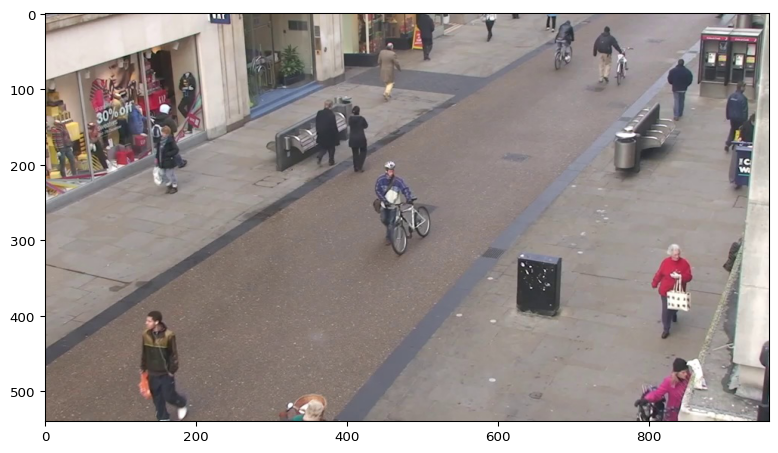

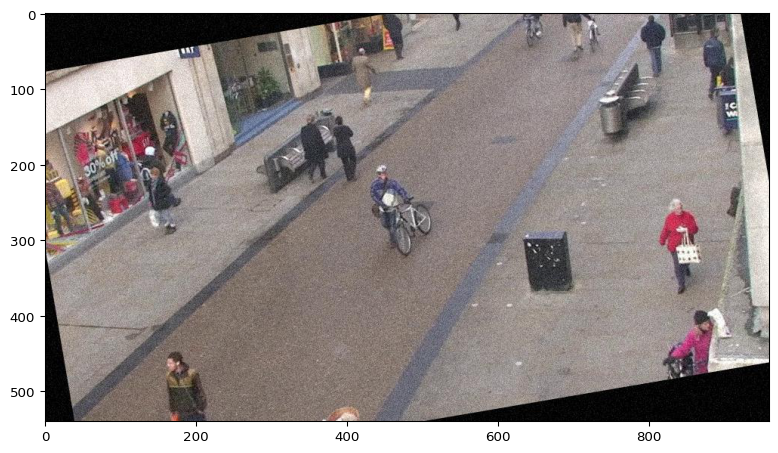

In [ ]:
simple_image = imageio.imread(train + "/" + "3.jpg")
augmented_image = imageio.imread(common_path +"/"+'aug_images/' + "aug1_3.jpg")
ia.imshow(simple_image)
ia.imshow(augmented_image)

<h3> Creating XML for Augmented data </h3>


In [ ]:
GT = ultimate_augment_df[[ "ids" , "xmin" , "ymin" , "xmax" , "ymax" ]]
GT = GT.dropna(axis = 0)
GT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43519 entries, 0 to 47721
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ids     43519 non-null  int64  
 1   xmin    43519 non-null  float32
 2   ymin    43519 non-null  float32
 3   xmax    43519 non-null  float32
 4   ymax    43519 non-null  float32
dtypes: float32(4), int64(1)
memory usage: 1.3 MB


In [ ]:
#Reference : https://github.com/thatbrguy/Pedestrian-Detection/blob/master/extract_GT.py

indent = lambda x,y: ''.join(['  ' for _ in range(y)]) + x

factor = 2
train_size = 3090

os.mkdir(common_path + "/" + 'xmls_augmented_1')
name = 'pedestrian'
width, height = 1920 // factor, 1080 // factor

for frame_number in tqdm(range(train_size)):
    
    if frame_number == 3076 or frame_number == 3082 or frame_number == 3086:
        continue
    
        
    Frame = GT.loc[GT["ids"] == frame_number] 
    x1 = list(Frame["xmin"])
    y1 = list(Frame["ymin"])
    x2 = list(Frame["xmax"])
    y2 = list(Frame["ymax"])

    points = [[(round(x1_), round(y1_)), (round(x2_), round(y2_))] for x1_,y1_,x2_,y2_ in zip(x1,y1,x2,y2)]

    with open(os.path.join(common_path + "/" + 'xmls_augmented_1', "aug1_" + str(frame_number) + '.xml'), 'w') as file:
        file.write('<annotation>\n')
        file.write(indent('<filename>' + "aug1_" + str(frame_number) + '.jpg' + '</filename>\n', 1))
        file.write(indent('<size>\n', 1))
        file.write(indent('<width>' + str(width) + '</width>\n', 2))
        file.write(indent('<height>' + str(height) + '</height>\n', 2))
        file.write(indent('<depth>3</depth>\n', 2))
        file.write(indent('</size>\n', 1))

        for point in points:

            top_left = point[0]
            bottom_right = point[1]

            if top_left[0] > bottom_right[0]:
                xmax, xmin = top_left[0] // factor, bottom_right[0] // factor
            else:
                xmin, xmax = top_left[0] // factor, bottom_right[0] // factor

            if top_left[1] > bottom_right[1]:
                ymax, ymin = top_left[1] // factor, bottom_right[1] // factor
            else:
                ymin, ymax = top_left[1] // factor, bottom_right[1] // factor

            file.write(indent('<object>\n', 1))
            file.write(indent('<name>' + name + '</name>\n', 2))
            file.write(indent('<bndbox>\n', 2))
            file.write(indent('<xmin>' + str(xmin) + '</xmin>\n', 3))
            file.write(indent('<ymin>' + str(ymin) + '</ymin>\n', 3))
            file.write(indent('<xmax>' + str(xmax) + '</xmax>\n', 3))
            file.write(indent('<ymax>' + str(ymax) + '</ymax>\n', 3))
            file.write(indent('</bndbox>\n', 2))
            file.write(indent('</object>\n', 1))


        file.write('</annotation>\n')

In [ ]:
len(os.listdir(common_path + "/xmls_augmented_1"))

3087

<h1> Using XML_df making train and val .record files </h1>

In [ ]:
#Reference : https://github.com/datitran/raccoon_dataset/blob/master/generate_tfrecord.py
def class_text_to_int(row_label):
    if row_label == 'pedestrian':
        return 1
    else:
        None


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


In [ ]:
def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example




In [ ]:
group_list = split(xml_df , "filename")
len(group_list)

3087

In [ ]:
xml_train = group_list[:int(0.8*len(group_list))]
xml_val = group_list[len(xml_train):]

print("Train size {} images".format(len(xml_train)))
print("val size {} images".format(len(xml_val)))


Train size 2469 images
val size 618 images


In [ ]:
def main(type_of_data , name):
    writer = tf.python_io.TFRecordWriter(common_path + name)
    path = train
    grouped = type_of_data
    for group in tqdm(grouped , ncols=100):
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())

    writer.close()
    output_path = common_path + "/train.record"
    print('Successfully created the TFRecords: {}'.format(output_path))

In [ ]:
#Creating train.record and val.record.
main(type_of_data=xml_train , name = "/train.record")
main(type_of_data=xml_val , name="/val.record")

<h1> Checking in the common path </h1>

In [19]:
os.listdir(common_path)

['TownCentre-calibration.ci',
 'TownCentre-groundtruth.top',
 'TownCentreXVID.mp4',
 'train',
 'test',
 'xmls',
 'aug_images',
 'xmls_augmented_1',
 'train.record',
 'val.record']

<h1> Observations </h1>

<pre>
Got all the desired files in the common_path :[
    'TownCentre-calibration.ci',        |
    'TownCentre-groundtruth.top',       |--Town-Hall-Data
    'TownCentreXVID.mp4',               |
    
    'train',       |
    'test',        |-- All the images data.
    'aug_images',  |
    
    'xmls',             |
    'xmls_augmented_1', |-- All the annotation in XML Format.
                        |

    'train.record',   |
    'val.record'      |-- All tf.record format for training.
                      |     (doesnt include augmnted data yet)
                        
    ]

Stored the Ultimate_data.pickle and ultimate_augmented_data.pickle 
in the system(its 4GB each) for backup.
    Structure of ultimate data :
        columns : [filename	
                  width
                  height
                  class	
                  xmin	
                  ymin	
                  xmax
                  ymax
                  ids
                  images]
        Shape   : (47722 rows × 10 columns)

</pre>